In [1]:
# written in python3
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import os
from datetime import datetime
import seaborn as sns
%matplotlib inline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values
    
plt.rcParams['figure.figsize'] = (10,6.180)    #golden ratio


def my_transform(data, label, degree, FEATURES):

    # LABEL = "Qw"
    LABEL = label
    PolynomialDegree = degree

    num_attribs = FEATURES
    cat_attribs = [LABEL]
    num_pipeline = Pipeline([
            ('selector', DataFrameSelector(num_attribs)),
            ('std_scaler', StandardScaler()),
            ('poly', PolynomialFeatures(degree=PolynomialDegree, include_bias=False))
        ])
    cat_pipeline = Pipeline([
            ('selector', DataFrameSelector(cat_attribs))
        ])

    full_pipeline = FeatureUnion(transformer_list=[
            ("num_pipeline", num_pipeline),
            ("cat_pipeline", cat_pipeline),
        ])
    return full_pipeline.fit_transform(data)

In [2]:
def choose_top(data, col="RMSD", n=5, ascending=True):
    return data.assign(chosen=pd.DataFrame.rank(data[col], ascending=ascending, method='dense')<=n)
folder_list = ["tr894", "tr884", "tr922", "tr882", "tr896", "tr872", "tr594", "tr862", "tr869", "tr898", "tr885", "tr866", "tr868", "tr891", "tr895", "tr870", "tr921", "tr877", "tr948", "tr947"]


raw_data_all = pd.read_csv("/Users/weilu/Research/frustration_selection/data.csv", index_col=0)

In [3]:
train_name_list = ["tr884"]
# select for training.
raw_data = raw_data_all.reset_index(drop=True).query(f'Protein in {train_name_list}')

In [4]:
raw_data_all.columns

Index(['Chain', 'Chi', 'Rama', 'DSSP', 'P_AP', 'Water', 'Burial', 'Helix',
       'Electro', 'VTotal', 'score', 'fa_atr', 'fa_rep', 'fa_sol',
       'fa_intra_rep', 'fa_intra_sol_xover4', 'lk_ball_wtd', 'fa_elec',
       'pro_close', 'hbond_sr_bb', 'hbond_lr_bb', 'hbond_bb_sc', 'hbond_sc',
       'omega', 'fa_dun', 'p_aa_pp', 'ref', 'rama_prepro', 'allatom_rms',
       'maxsub', 'maxsub2.0', 'description', 'Q', 'RMSD', 'GDT', 'Protein',
       'chosen'],
      dtype='object')

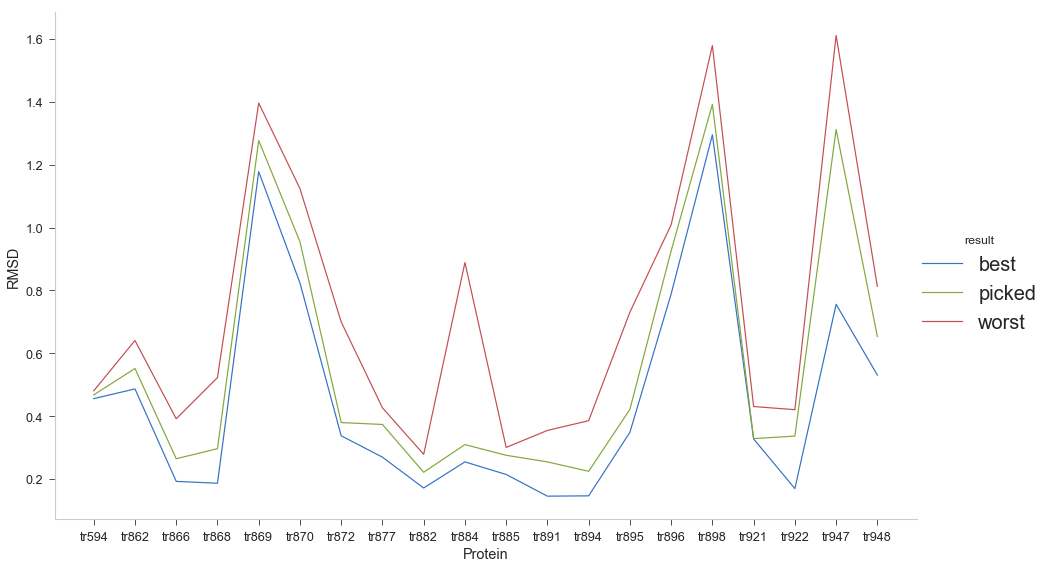

In [5]:
# FEATURES = ["eigenvalues", "entropy", "pca"]
# FEATURES = ["eigenvalues", "entropy", "diffRMSD"]
# FEATURES = ["eigenvalues", "entropy"]
FEATURES = [
#     "biasQ",
#     'score',
#      'VTotal',
    'DSSP', 'P_AP', 'Water', 'Burial', 'Helix', 'Electro', 
    'fa_atr', 'fa_rep', 'fa_sol', 
    'fa_intra_rep', 'fa_intra_sol_xover4', 'lk_ball_wtd', 'fa_elec',
    'pro_close', 'hbond_sr_bb', 'hbond_lr_bb', 'hbond_bb_sc', 'hbond_sc',
    'omega', 'fa_dun', 'p_aa_pp', 'rama_prepro', 'allatom_rms', 'maxsub', 'maxsub2.0'
#     'RMSD', # test
#     'Qw',
#      'Burial',
#      'Water',
#      'Rama',
#      'DSSP',
#      'P_AP',
#      'Helix',
#      'Frag_Mem'
               ]
# FEATURES = ["eigenvalues"]
# LABEL = "diffRMSD"
# LABEL = "RMSD"
LABEL = "chosen"
DEGREE = 1

def pred_from_raw(a):
    data = my_transform(a, label=LABEL, degree=DEGREE, FEATURES=FEATURES)
    test_y = data[:,-1]
    test_set = data[:,:-1]
    prob= clf.predict_proba(test_set)[:,1]
    return a.assign(prob=prob)

# data = my_transform(raw_data, label=LABEL, degree=DEGREE, FEATURES=FEATURES)
# data = raw_data.groupby('name').apply(my_transform, label=LABEL, degree=DEGREE, FEATURES=FEATURES)[0]
data = np.concatenate(raw_data.groupby('Protein').apply(my_transform, 
                                                     label=LABEL, degree=DEGREE, FEATURES=FEATURES).values)
train_y = data[:,-1]
train_set = data[:,:-1]

# clf = svm.SVC(probability=True)
# p = 0.01
# clf = LogisticRegression(random_state=27, class_weight={0:p, 1:(1-p)})
clf = LogisticRegression(random_state=1127, solver="lbfgs")
clf.fit(train_set, train_y)

filtered = raw_data_all.groupby("Protein").apply(pred_from_raw).reset_index(drop=True)


picked_n = 1
best = raw_data_all.groupby("Protein").apply(choose_top, col="RMSD"
                                            , n=1, ascending=True).reset_index(drop=True).query("chosen==True")
# if True:
picked_1 = filtered.groupby("Protein").apply(choose_top, col="prob"
                                        , n=1, ascending=False).reset_index(drop=True).query("chosen==True")

# if False:
picked_5 = filtered.groupby("Protein").apply(choose_top, col="prob"
                                            , n=5, ascending=False).reset_index(drop=True).query("chosen==True")
picked = picked_5.groupby("Protein").apply(choose_top, col="RMSD"
                                            , n=1, ascending=True).reset_index(drop=True).query("chosen==True")
worst = filtered.groupby("Protein").apply(choose_top, col="RMSD"
                                            , n=1, ascending=False).reset_index(drop=True).query("chosen==True")
# init = raw_data_all.groupby("Protein").apply(choose_top, col="i"
#                                             , n=1, ascending=True).reset_index(drop=True).query("chosen==True")
all_results = pd.concat([best.assign(result='best'), 
                         picked_1.assign(result='picked'), 
#                          picked.assign(result='picked_5'), 
#                          init.assign(result='init'),
                        worst.assign(result='worst')
                        ], sort=False)
# all_results = pd.concat([best.assign(result='best'), 
#                          picked.assign(result='picked')])
# picked.to_csv("/Users/weilu/Desktop/picked.csv

# sns.set(rc={'figure.figsize':(20,30)})
# plt.figure(figsize=(15,8))
fg = sns.FacetGrid(data=all_results.reset_index(), hue='result', height=8, aspect=1.63)
fg.map(plt.plot, 'Protein', 'RMSD').add_legend(fontsize=20)
# fg.set(ylim=(0, 10))

In [6]:
for pdb in folder_list:
    print(pdb, round(10*picked_1.query(f"Protein=='{pdb}'")["RMSD"].values[0], 3))

tr894 2.25
tr884 3.1
tr922 3.37
tr882 2.22
tr896 9.26
tr872 3.8
tr594 4.68
tr862 5.52
tr869 12.77
tr898 13.92
tr885 2.76
tr866 2.65
tr868 2.97
tr891 2.55
tr895 4.22
tr870 9.55
tr921 3.29
tr877 3.74
tr948 6.54
tr947 13.12


In [7]:
clf.coef_

array([[ 1.41690418e-01, -6.54233033e-01, -6.32444358e-01,
         3.68453940e-01, -1.49686419e-02,  6.16596922e-01,
        -1.99938357e+00, -3.79186540e-01, -1.47851699e+00,
        -1.03377756e-04, -3.45064808e-01,  7.08020836e-02,
        -3.11817764e-01, -2.52288431e-01,  1.66044718e-01,
         6.31737501e-01, -5.31627810e-01,  5.45306519e-01,
        -3.70503149e-01,  2.62508369e-01, -3.08770338e-01,
        -8.17160316e-01,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00]])

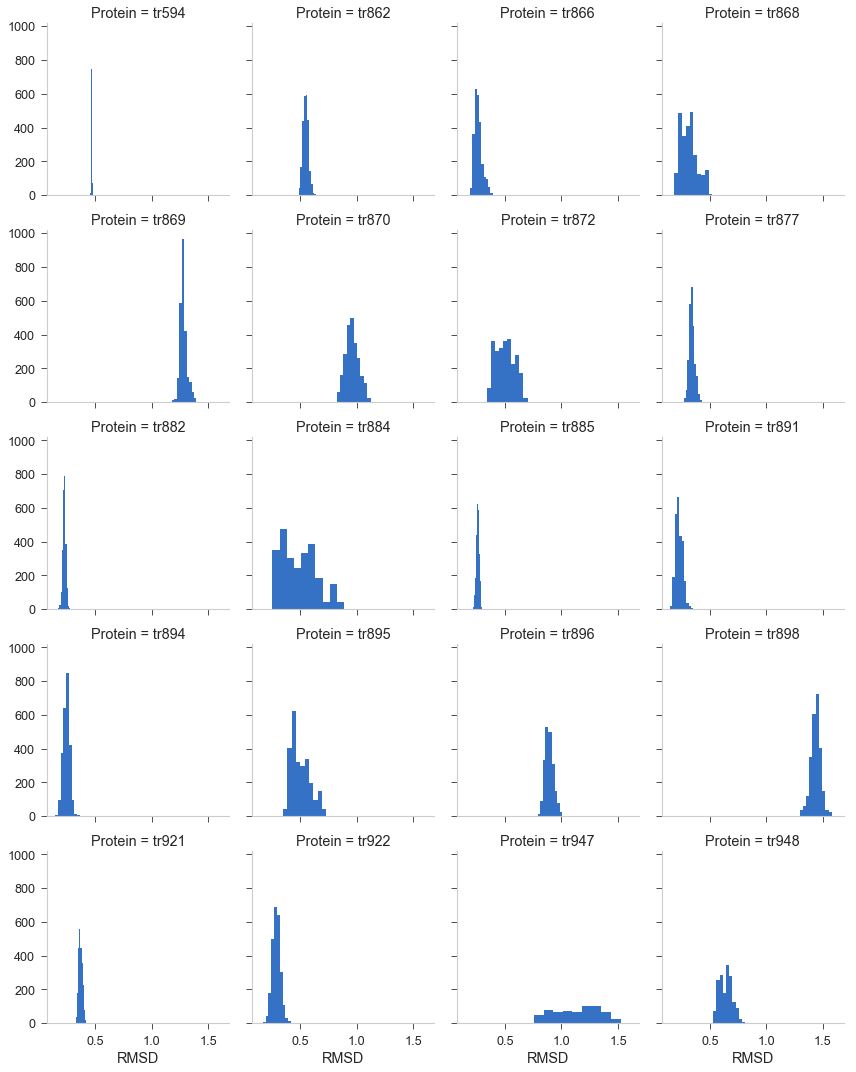

In [8]:
g = sns.FacetGrid(raw_data_all, col="Protein", col_wrap=4)
g = g.map(plt.hist, "RMSD")

In [9]:
# import glob
# a = glob.glob("/Users/weilu/Research/frustration_selection/tr*")
# print(len(a))
# pdb_list = [i.split("/")[-1] for i in a]
# all_ = []
# for pdb in pdb_list:
#     #     print(pdb)
#     fileLocation = f"/Users/weilu/Research/frustration_selection/{pdb}/q.txt"
#     q = np.loadtxt(fileLocation)
#     fileLocation = f"/Users/weilu/Research/frustration_selection/{pdb}/rmsd.txt"
#     rmsd = np.loadtxt(fileLocation)
#     fileLocation = f"/Users/weilu/Research/frustration_selection/{pdb}/gdt.txt"
#     gdt = np.loadtxt(fileLocation)
#     fileLocation = f"/Users/weilu/Research/frustration_selection/{pdb}/awsem_energy.txt"
#     awsem_column = ['Step', 'Chain', 'Shake', 'Chi', 'Rama', 'Excluded', 'DSSP', 'P_AP', 'Water', 'Burial', 'Helix', 'AMH-Go', 'Frag_Mem', 'Vec_FM', 'Membrane', 'SSB', 'Electro', 'QGO', 'VTotal']
#     awsem = pd.read_csv(fileLocation, sep="\s+", names=awsem_column)
#     fileLocation = f"/Users/weilu/Research/frustration_selection/{pdb}/rosetta_energy.txt"
#     rosetta = pd.read_csv(fileLocation, sep="\s+")
#     data = pd.concat([awsem, rosetta], axis=1)
#     assert len(awsem) == len(rosetta) == len(q) == len(rmsd) == len(gdt)
#     data["Q"] = q
#     data["RMSD"] = rmsd
#     data["GDT"] = gdt
#     data["Protein"] = pdb
#     all_.append(data)
# #     print(pdb, len(data))
# data = pd.concat(all_)

# drop_col = []
# for col in data.columns:
# #     print(col, len(data[col].unique()))
#     if len(data[col].unique()) == 1:
#         drop_col.append(col)
# data = data.drop(drop_col, axis=1)

# def extract_frame(data):
#     return int(data.split("_")[0])
# data["description"] = data["description"].apply(extract_frame)
# raw_data_all = data.groupby("Protein").apply(choose_top, n=100, col="RMSD").reset_index(drop=True)
# # raw_data_all.to_csv("/Users/weilu/Research/frustration_selection/data.csv")